<a href="https://colab.research.google.com/github/martins-jean/Employee-turnover-prediction-in-R/blob/main/turnover_prediction_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**I. Required setup**

In [ ]:
# Install the necessary packages
install.packages("tidyverse")
install.packages("Information")
install.packages("caret")

In [ ]:
# Load the essential libraries
library(readr)
library(dplyr)
library(ggplot2)
library(lubridate, warn.conflicts = FALSE)
library(Information)
library(caret)

**II. Exploratory data analysis (EDA)**

<p align="justify">Since employee information is confidential, I will be working with artificially generated employee data related to the year 2014. </p>

In [ ]:
# Import the org.csv data
org <- read_csv("https://raw.githubusercontent.com/martins-jean/Employee-Turnover-Prediction-in-R/main/org.csv")

In [4]:
# Check the structure of the org dataset
glimpse(org)


Rows: 2,291
Columns: 14
$ emp_id            <chr> "E11061", "E1031", "E6213", "E5900", "E3044", "E4008…
$ status            <chr> "Inactive", "Inactive", "Inactive", "Inactive", "Ina…
$ turnover          <dbl> 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0…
$ location          <chr> "New York", "New York", "New York", "New York", "Flo…
$ level             <chr> "Analyst", "Analyst", "Analyst", "Analyst", "Analyst…
$ date_of_joining   <chr> "22/03/2012", "09/03/2012", "06/01/2012", "22/03/201…
$ date_of_birth     <chr> "22/03/1992", "10/01/1992", "06/02/1992", "19/12/199…
$ last_working_date <chr> "11/09/2014", "05/06/2014", "30/04/2014", "09/04/201…
$ gender            <chr> "Male", "Female", "Female", "Female", "Female", "Fem…
$ department        <chr> "Customer Operations", "Customer Operations", "Custo…
$ mgr_id            <chr> "E1712", "E10524", "E4443", "E3638", "E3312", "E1393…
$ cutoff_date       <chr> "31/12/2014", "31/12/2014", "31/12/2014", "31/12/201…
$ generation    

**What is the overall turnover rate?**

In this dataset, employees who are described as "Active" are those who stayed in the company at the end of the year 2014. <br>
By contrast, "Inactive" employees represent the ones who left and exemplify turnover.

In [5]:
# Count the number of employees of "Active" versus "Inactive" employees
org %>%
  count(status)

status,n
<chr>,<int>
Active,1881
Inactive,410


In [6]:
# Calculate the overall turnover rate
org %>%
  summarize(avg_turnover_rate = mean(turnover))

avg_turnover_rate
<dbl>
0.1789612


According to SHRM, the leading HR professional association, companies should aim for a turnover rate not exceeding 10%. <br>

in this case, we see a turnover rate of almost 18% which, despite being average across industries, is still far above the recommended level.

Can we drill down further to understand turnover across different dimensions?

**How is turnover affected by employee levels?**

In [7]:
# Differentiate turnover by the employee level
df_level <- org %>%
  group_by(level) %>%
  summarize(turnover_level = mean(turnover))

In [8]:
# Check the results
df_level

level,turnover_level
<chr>,<dbl>
Analyst,0.21508728
Assistant Manager,0.03645833
Director,0.00000000
Manager,0.04347826
Senior Manager,0.00000000
Specialist,0.14857143
Vice President,0.00000000


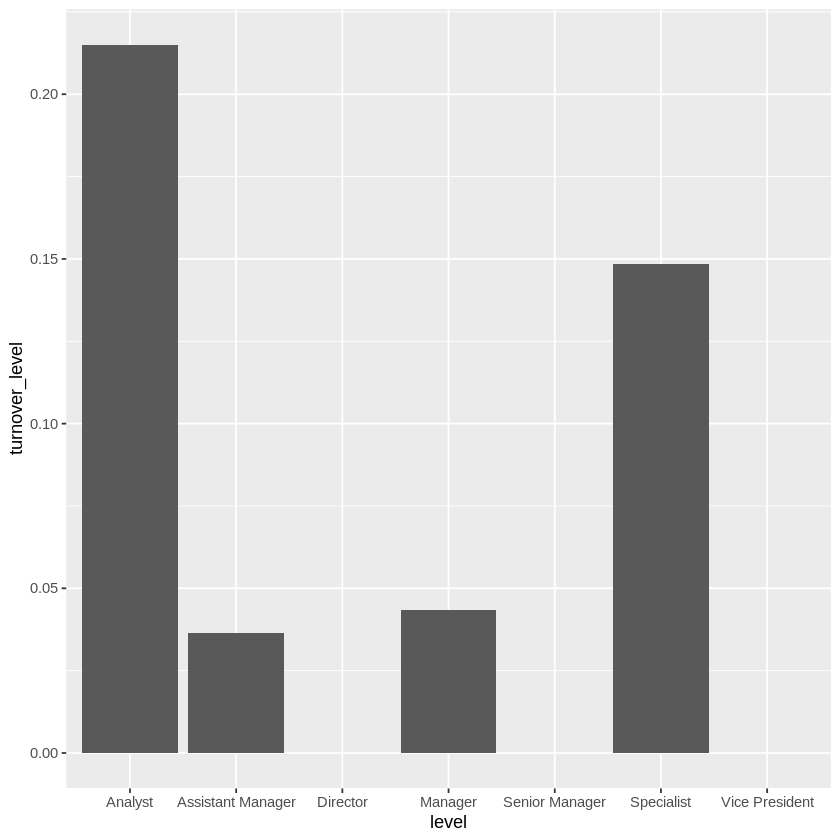

In [9]:
# Visualize turnover by employee level
ggplot(df_level, aes(x = level, y = turnover_level)) + geom_col()

We can see turnover affects mostly the "Analyst" and "Specialist" levels. <br>
There is some turnover among mid-management but it much lower than for non-managerial roles. <br>
There is no turnover at all in 2014 for the senior managment and leadership roles.

**How is turnover affected by office locations?**

In [10]:
# Differentiate turnover by office location
df_location <- org %>%
  group_by(location) %>%
  summarize(turnover_location = mean(turnover))

In [11]:
# Check the results
df_location

location,turnover_location
<chr>,<dbl>
Chicago,0.3256410
Florida,0.1055133
New York,0.2025913


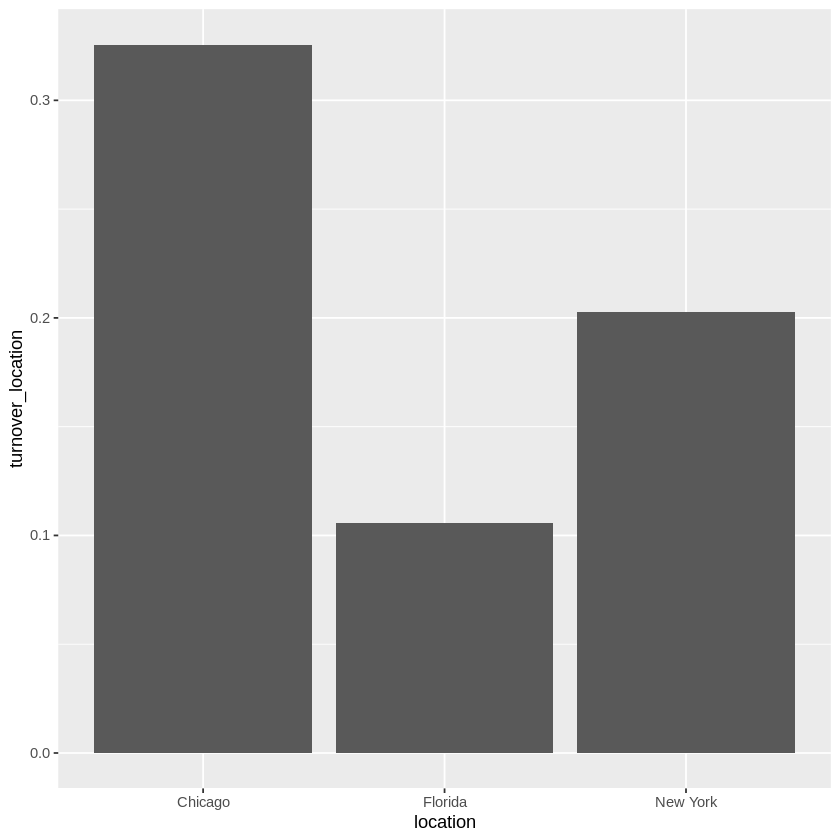

In [12]:
# Visualize turnover by office location
ggplot(df_location, aes(x = location, y = turnover_location)) + geom_col()

We see that turnover affects the three offices included in the dataset but Chicago is by far the most affected location. <br>

**Removing managerial levels from our analysis**

We will now separate the data into talent segments by filtering out managerial and executive roles.

In [13]:
# Count the number of employees across levels
org %>%
  count(level)

level,n
<chr>,<int>
Analyst,1604
Assistant Manager,192
Director,1
Manager,138
Senior Manager,5
Specialist,350
Vice President,1


In [14]:
# Select only the employees at the "Analyst" and "Specialist" levels
org2 <- org %>%
  filter(level %in% c("Analyst", "Specialist"))

In [15]:
# Validate the results
org2 %>%
  count(level)

level,n
<chr>,<int>
Analyst,1604
Specialist,350


**How is turnover affected by employee performance ratings?**

Employee performance is often linked to turnover so let's explore that axis now by leveraging the 2013 ratings included in the "rating.csv" file.

In [ ]:
# Import the rating data
rating <- read_csv("https://raw.githubusercontent.com/martins-jean/Employee-Turnover-Prediction-in-R/main/rating.csv")

In [17]:
# View the structure of the rating dataset
glimpse(rating)

Rows: 1,954
Columns: 2
$ emp_id <chr> "E8", "E9", "E12", "E15", "E34", "E37", "E47", "E50", "E53", "E…
$ rating <chr> "Acceptable", "Acceptable", "Acceptable", "Acceptable", "Accept…


In [18]:
# Join the rating to the org2 dataset
org3 <- left_join(org2, rating, by = "emp_id")

In [19]:
# Differentiate turnover by employee performance ratings
df_rating <- org3 %>%
  group_by(rating) %>%
  summarize(turnover_rating = mean(turnover))

In [20]:
# Check the result
df_rating

rating,turnover_rating
<chr>,<dbl>
Above Average,0.13129496
Acceptable,0.22097378
Below Average,0.38461538
Excellent,0.03053435
Unacceptable,0.63333333


We verify that employees who received a "Unacceptable" performance rating were the most likely to leave the organization. <br>
Contrary to this, excellent performers were the least likely to leave.

**How is turnover affected by manager effectiveness?**

It is often said that people leave managers not companies so let's explore how "manager effectiveness" affects turnover.

In [ ]:
# Import the survey data
survey <- read_csv("https://raw.githubusercontent.com/martins-jean/Employee-Turnover-Prediction-in-R/main/survey.csv")

In [22]:
# View the structure of the survey dataset
glimpse(survey)

Rows: 350
Columns: 5
$ mgr_id              <chr> "E1003", "E10072", "E10081", "E10234", "E1026", "E…
$ mgr_effectiveness   <dbl> 0.760, 0.650, 0.800, 0.650, 0.700, 0.980, 0.520, 0…
$ career_satisfaction <dbl> 0.76, 0.67, 0.82, 0.63, 1.00, 0.91, 0.56, 0.91, 0.…
$ perf_satisfaction   <dbl> 0.71, 0.56, 0.73, 0.75, 1.00, 0.91, 0.50, 0.88, 0.…
$ work_satisfaction   <dbl> 0.82, 0.84, 0.84, 0.70, 0.92, 0.77, 0.81, 0.84, 0.…


In [23]:
# Join survey to the org3 dataset
org_final <- left_join(org3, survey, by = "mgr_id")

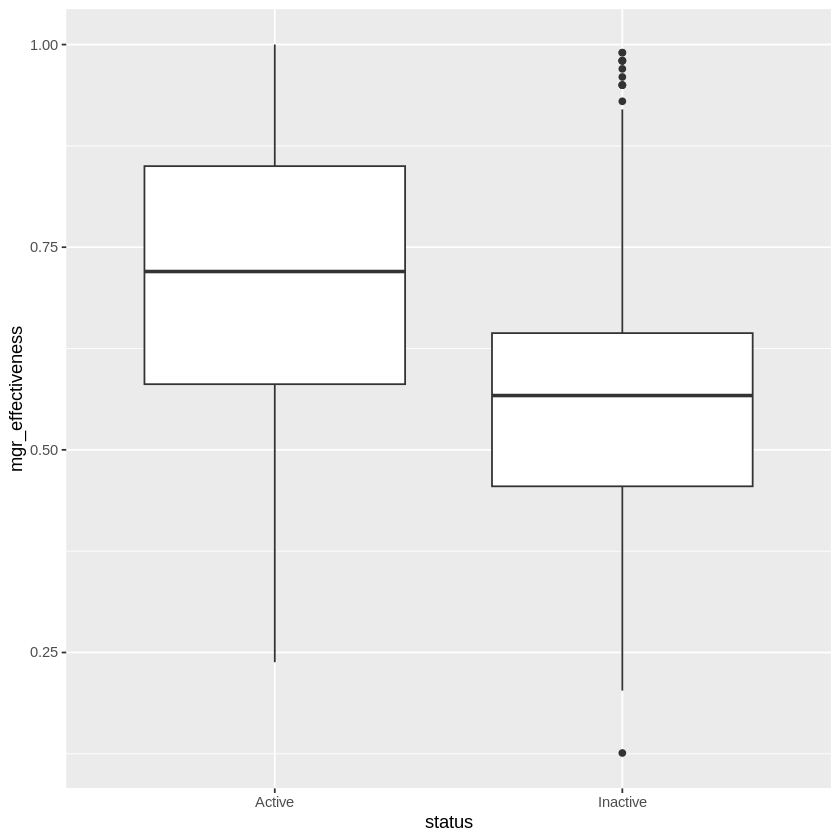

In [24]:
# Visualize and compare manager effectiveness scores
ggplot(org_final, aes(x = status, y = mgr_effectiveness)) + geom_boxplot()

We see that the employees who stayed had managers with a much higher median effectiveness.

<p align="justify">Using the above datasets allowed us to demonstrate a series of useful visualizations and how we can build our final dataset progressively but from now on, we will augment our data in a faster way by using another version of the org_final dataset which contains 34 variables as opposed to the original 19 we had when we joined the three initial datasets.</p>

In [ ]:
# Import the new augmented final dataset
org_final <- read_csv("https://raw.githubusercontent.com/martins-jean/Employee-Turnover-Prediction-in-R/main/org_final.csv")

In [26]:
# View the structure of the new org_final dataset
glimpse(org_final)

Rows: 1,954
Columns: 34
$ emp_id                       <chr> "E10012", "E10025", "E10027", "E10048", "…
$ status                       <chr> "Active", "Active", "Active", "Active", "…
$ location                     <chr> "New York", "Chicago", "Orlando", "Chicag…
$ level                        <chr> "Analyst", "Analyst", "Specialist", "Spec…
$ gender                       <chr> "Female", "Female", "Female", "Male", "Ma…
$ emp_age                      <dbl> 25.09, 25.98, 33.40, 24.55, 31.23, 31.98,…
$ rating                       <chr> "Above Average", "Acceptable", "Acceptabl…
$ mgr_rating                   <chr> "Acceptable", "Excellent", "Above Average…
$ mgr_reportees                <dbl> 9, 4, 6, 10, 11, 19, 21, 9, 12, 22, 17, 1…
$ mgr_age                      <dbl> 44.07, 35.99, 35.78, 26.70, 34.28, 34.82,…
$ mgr_tenure                   <dbl> 3.17, 7.92, 4.38, 2.87, 12.95, 10.88, 4.0…
$ compensation                 <dbl> 64320, 48204, 85812, 49536, 75576, 56904,…
$ percent_hike  

In [27]:
# Register the number of variables in the new dataset
variables <- 34

**How is turnover affected by commuting distance?**

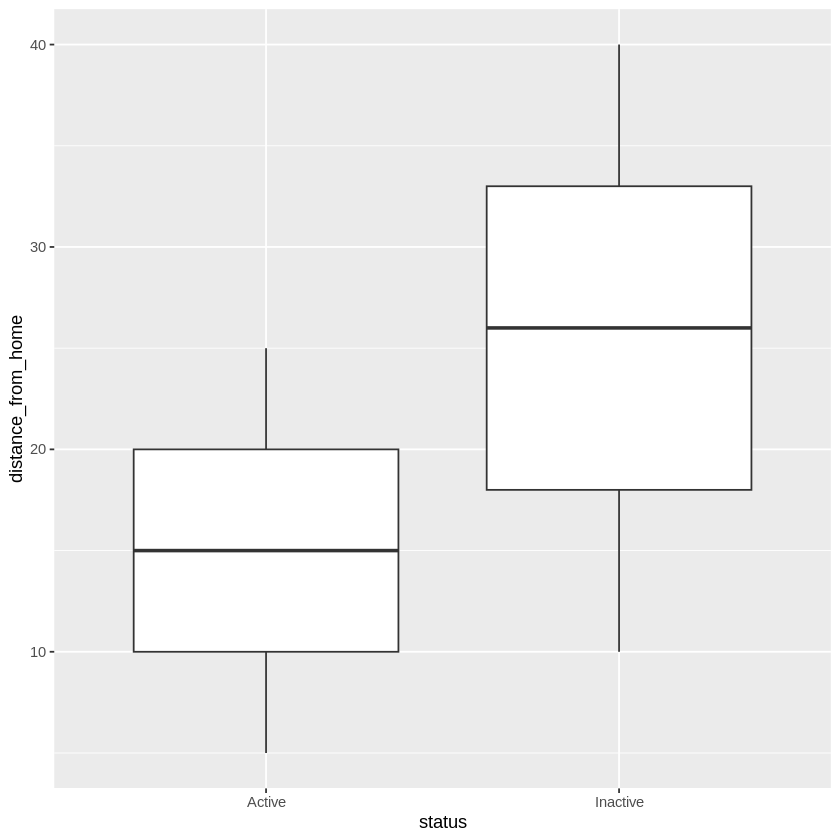

In [28]:
# Compare the travel distance of Active and Inactive employees
ggplot(org_final, aes(x = status, y = distance_from_home)) + geom_boxplot()

The median distance from an employee's home was much higher for "Inactive" employees.

**III. Feature engineering**

It allows to derive new variables from the ones already present in the dataset. <br> The three new features we will create are: <br>
- age difference between the employee and the manager <br>
- job-hop index (total experience divided by the number of companies worked at) <br>
- employee tenure (duration of employment)

In [29]:
# Derive the age difference variable
emp_age_diff <- org_final %>%
  mutate(age_diff = mgr_age - emp_age)

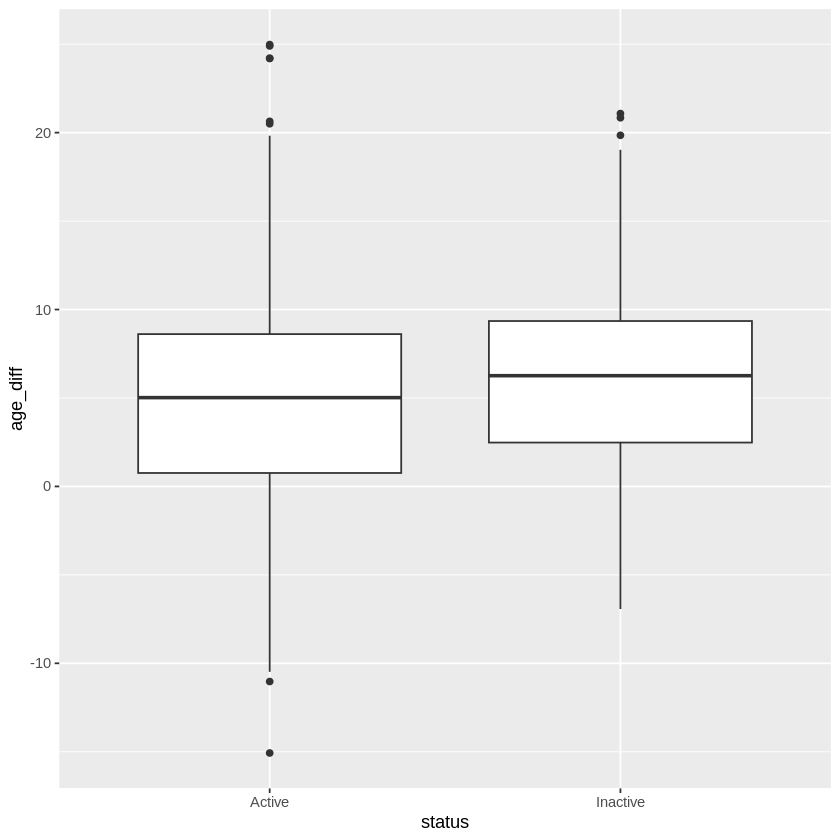

In [30]:
# Plot the distribution of age differences
ggplot(emp_age_diff, aes(x = status, y = age_diff)) + geom_boxplot()

The age difference between employees and their managers was slightly higher for "Inactive" employees. <br>
However, this result is not as significant as previous results we had with other features.

In [31]:
# Derive the job-hop index
emp_jhi <- emp_age_diff %>%
  mutate(job_hop_index = total_experience / no_previous_companies_worked)

Warning message:
“Removed 186 rows containing non-finite values (`stat_boxplot()`).”


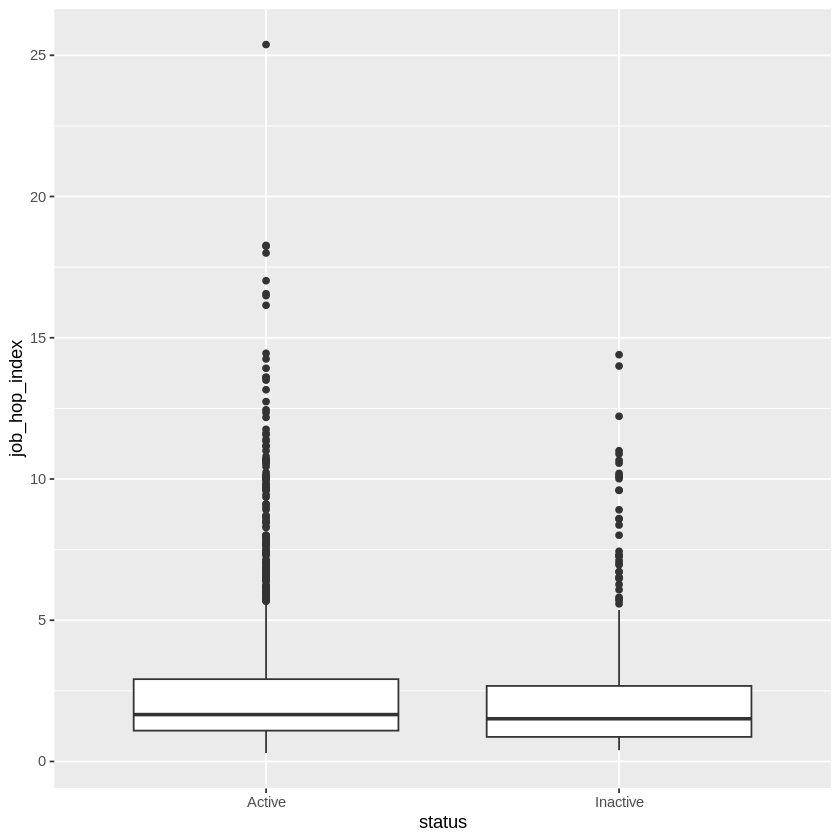

In [32]:
# Compare job hopping index of Active and Inactive employees
ggplot(emp_jhi, aes(x = status, y = job_hop_index)) + geom_boxplot()

We can see that the job hop index is also not as strong as other indicators.

In [33]:
# Derive the employee tenure
emp_tenure <- emp_jhi %>%
  mutate(
    date_of_joining = as.Date(date_of_joining),  # Convert to Date format
    cutoff_date = as.Date(cutoff_date),          # Convert to Date format
    last_working_date = as.Date(last_working_date), # Convert to Date format
    tenure = ifelse(
      status == "Active",
      time_length(interval(date_of_joining, cutoff_date), "years"),
      time_length(interval(date_of_joining, last_working_date), "years")
    )
  )

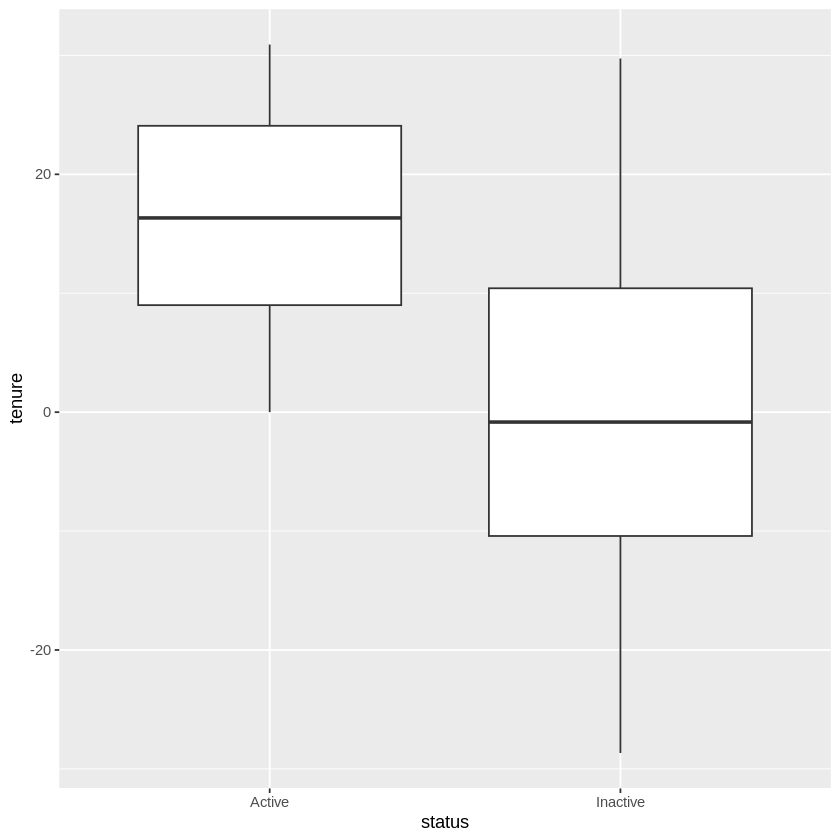

In [34]:
# Compare tenure of Active and Inactive employees
ggplot(emp_tenure, aes(x = status, y = tenure)) + geom_boxplot()

Tenure is clearly linked to turnover rate with "Inactive" employees displaying a much shorter tenure.

**How does compensation impact turnover at this firm?**

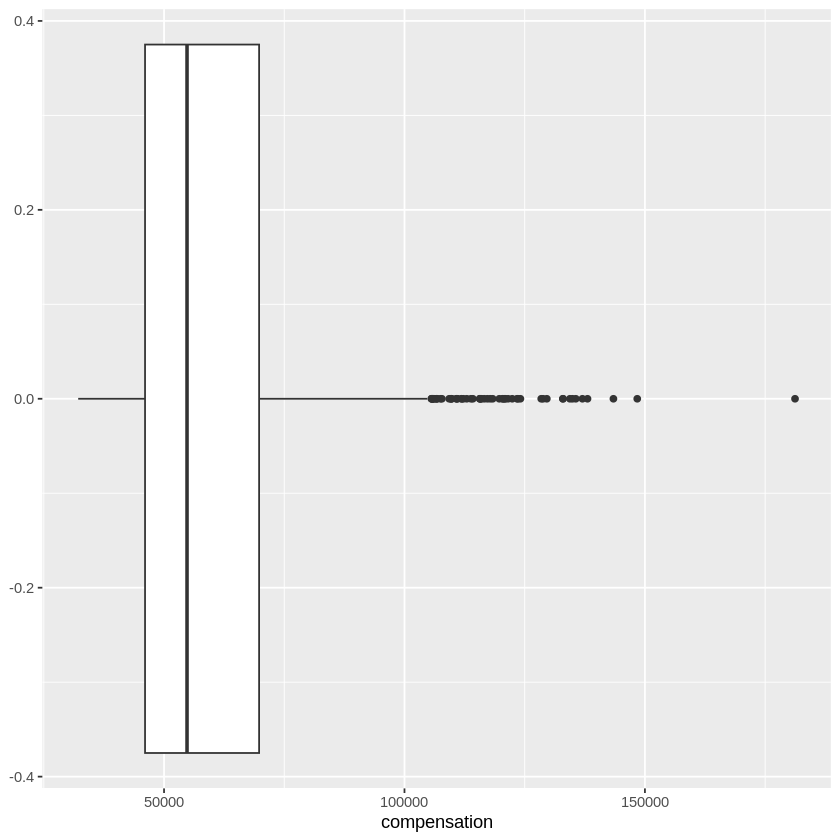

In [35]:
# Plot the overall distribution of compensation
ggplot(emp_tenure, aes(x = compensation)) + geom_boxplot()

Most employees at this firm receive between 45,000 and 75,000.

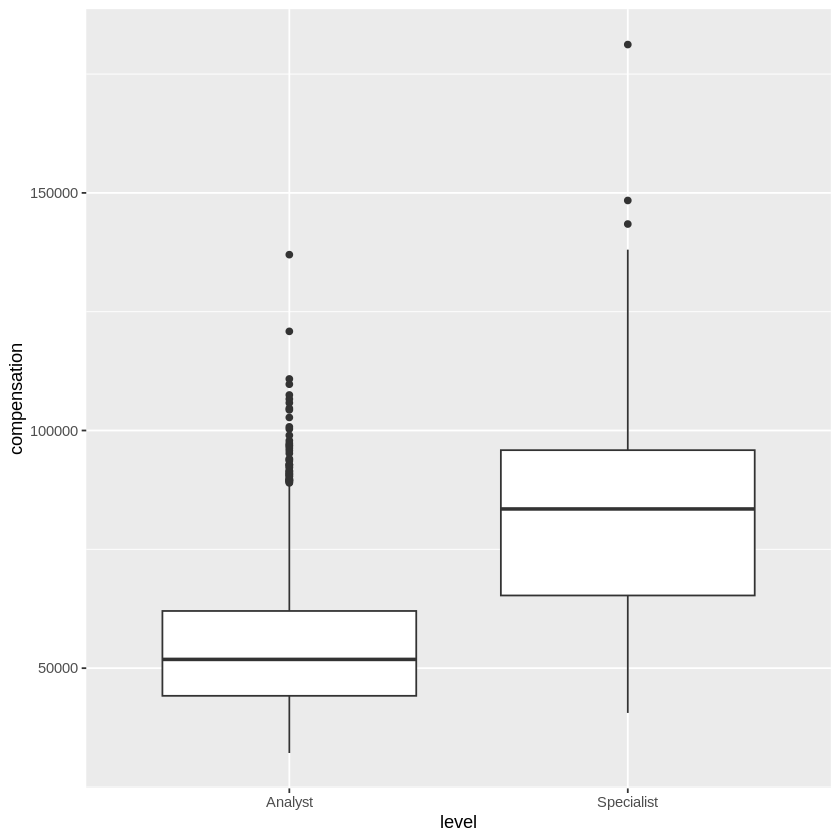

In [36]:
# Plot the distribution of compensation across levels
ggplot(emp_tenure, aes(x = level, y = compensation)) + geom_boxplot()

We discover that the median compensation for the "Specialist" level is much higher than for the "Analyst" level.

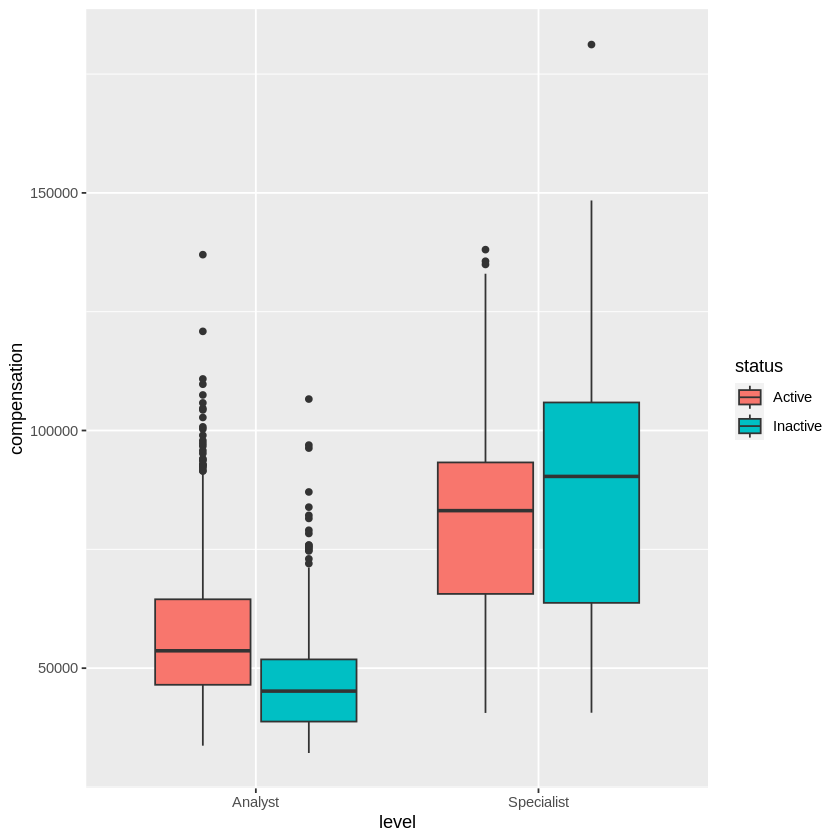

In [37]:
# Compare compensation across Active and Inactive employees
ggplot(emp_tenure, aes(x = level, y = compensation, fill = status)) + geom_boxplot()

Employees always expect to be paid fairly in comparison to their peers. We will now use the compa-ratio measure to assess internal pay parity.

In [38]:
# Add the median compensation and compa-ratio variables
emp_compa_ratio <- emp_tenure %>%
  group_by(level) %>%
  mutate(median_compensation = median(compensation),
         compa_ratio = compensation / median_compensation)

In [39]:
# Look at the median compensation for each level
emp_compa_ratio %>%
  distinct(level, median_compensation)

level,median_compensation
<chr>,<dbl>
Analyst,51840
Specialist,83496


There is a clear difference between the median compensation of "Analyst" and "Specialist". <br> A compa-ratio above 1 means that the employee is paid above the median compensation.

In [40]:
# Deriving the compa-level to represent a quick and visible evaluation of the compa-ratio for different employees
emp_final <- emp_compa_ratio  %>%
  mutate(compa_level = ifelse(compa_ratio > 1, "Above", "Below"))

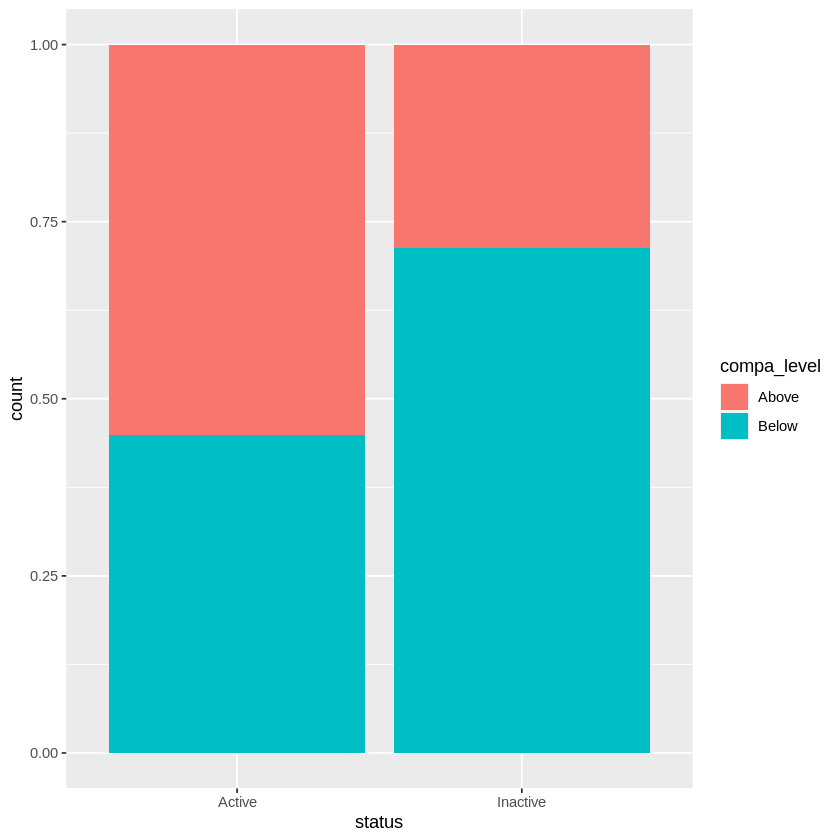

In [41]:
# Compare compa_level for Active & Inactive employees
ggplot(emp_final, aes(x = status, fill = compa_level)) +
  geom_bar(position = "fill")

A higher proportion of "Inactive" employees had a lower compa-ratio.

**Using the concept of Information Value (IV) to identify predictive power**

In [42]:
# Compute Information Value
IV <- create_infotables(data = emp_final, y = "turnover")

[1] "Variable emp_id was removed because it is a non-numeric variable with >1000 categories"
[1] "Variable date_of_joining was removed because it is a Date variable"
[1] "Variable last_working_date was removed because it is a Date variable"
[1] "Variable department was removed because it has only 1 unique value"
[1] "Variable cutoff_date was removed because it is a Date variable"


In [43]:
# Print the Information Value
IV$Summary

,Variable,IV
,<chr>,<dbl>
12,percent_hike,1.144784e+00
17,total_dependents,1.088645e+00
21,no_leaves_taken,9.404533e-01
31,tenure,7.636901e-01
25,mgr_effectiveness,6.830020e-01
11,compensation,6.074885e-01
33,compa_ratio,4.768892e-01
6,rating,3.869373e-01
23,monthly_overtime_hrs,3.786644e-01


An IV lower than 0.15 has weak predictive power, between 0.15 and 0.4 it is moderate and beyond 0.4 it is strong.

**IV. Data preparation**

We will now split the data between a training and a testing dataset.

In [44]:
# Preparing the dataset to avoid subsequent errors when building the multiple regression model
reduced_emp_final <- emp_final %>%
  select(status, location, level, rating, percent_hike, hiring_score, distance_from_home,
        monthly_overtime_hrs, mgr_effectiveness, tenure, age_diff, compa_level, turnover)

In [45]:
reduced_emp_final

status,location,level,rating,percent_hike,hiring_score,distance_from_home,monthly_overtime_hrs,mgr_effectiveness,tenure,age_diff,compa_level,turnover
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Active,New York,Analyst,Above Average,10,70,14,1,0.730,25.7513661,18.98,Above,0
Active,Chicago,Analyst,Acceptable,8,70,21,5,0.581,8.2486339,10.01,Below,0
Active,Orlando,Specialist,Acceptable,11,77,15,3,0.770,29.0819672,2.38,Above,0
Active,Chicago,Specialist,Acceptable,8,71,9,8,0.240,11.5846995,2.15,Below,0
Active,Orlando,Analyst,Acceptable,12,70,25,1,0.710,10.0000000,3.05,Above,0
Inactive,Orlando,Analyst,Below Average,8,75,23,7,0.574,-6.7513661,2.84,Above,1
Active,Chicago,Analyst,Acceptable,12,72,17,2,0.600,1.7513661,0.06,Below,0
Active,Orlando,Analyst,Above Average,9,70,16,10,0.750,6.0819672,3.29,Above,0
Active,New York,Analyst,Acceptable,9,70,22,2,0.470,10.2486339,4.74,Below,0


In [46]:
# Set the seed of 567
set.seed(567)

In [47]:
# Store row numbers for training dataset: index_train
index_train <- createDataPartition(reduced_emp_final$turnover, p = 0.7, list = FALSE)

In [48]:
# Create a training dataset
train_set <- reduced_emp_final[index_train, ]

In [49]:
# Create test dataset
test_set <- reduced_emp_final[-index_train, ]

Let's now make sure both datasets have a similar proportion of "Active" and "Inactive" employees.

In [50]:
# Calculate turnover proportion in train_set
train_set %>%
  count(status) %>%
  mutate(prop = n / sum(n))

level,status,n,prop
<chr>,<chr>,<int>,<dbl>
Analyst,Active,882,0.7917415
Analyst,Inactive,232,0.2082585
Specialist,Active,212,0.8346457
Specialist,Inactive,42,0.1653543


In [51]:
# Calculate turnover proportion in test_set
test_set %>%
  count(status) %>%
  mutate(prop = n / sum(n))

level,status,n,prop
<chr>,<chr>,<int>,<dbl>
Analyst,Active,377,0.7693878
Analyst,Inactive,113,0.2306122
Specialist,Active,86,0.8958333
Specialist,Inactive,10,0.1041667


**V. Model creation**

In [52]:
# Build a simple logistic regression model
simple_log <- glm(turnover ~ percent_hike,
                  family = "binomial", data = train_set)

In [53]:
# Print summary
summary(simple_log)


Call:
glm(formula = turnover ~ percent_hike, family = "binomial", data = train_set)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.37851    0.21950    6.28 3.38e-10 ***
percent_hike -0.29762    0.02396  -12.42  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1370.2  on 1367  degrees of freedom
Residual deviance: 1176.7  on 1366  degrees of freedom
AIC: 1180.7

Number of Fisher Scoring iterations: 5


The significance codes indicate how certain we can be that the independent variable has an impact on the dependent variable. <br>
An employee's decision to leave an organization usually depends on many factors so we will now use a multiple logistic regression model.

In [54]:
# Build a multiple logistic regression model
multi_log <- glm(turnover ~ ., family = "binomial",
                 data = train_set, control = glm.control(maxit = 50))

In [55]:
# Print summary
summary(multi_log)


Call:
glm(formula = turnover ~ ., family = "binomial", data = train_set, 
    control = glm.control(maxit = 50))

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)
(Intercept)          -2.957e+01  1.026e+06       0        1
statusInactive        5.913e+01  1.644e+05       0        1
locationNew York     -2.105e-12  1.303e+05       0        1
locationOrlando      -1.570e-12  9.841e+04       0        1
levelSpecialist      -5.642e-13  1.131e+05       0        1
ratingAcceptable     -5.617e-13  1.083e+05       0        1
ratingBelow Average   2.935e-12  2.116e+05       0        1
ratingExcellent      -3.119e-13  1.956e+05       0        1
ratingUnacceptable    5.204e-11  4.254e+05       0        1
percent_hike          1.536e-13  1.966e+04       0        1
hiring_score          6.205e-14  1.361e+04       0        1
distance_from_home   -3.558e-13  6.542e+03       0        1
monthly_overtime_hrs -6.554e-14  1.244e+04       0        1
mgr_effectiveness    -9.299e-13

**The issue of multicollinearity**

If several variables are strongly related, they don't provide any new linearly independent information that can help predict the outcome.